In [ ]:
!pip3 install keras-visualizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pathlib
import os
import librosa
import json

from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
from IPython import display
from keras_visualizer import visualizer


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


cd /content/drive/MyDrive/BANGKIT

!unzip /content/drive/MyDrive/dikeluarin_fixbgt.zip

In [ ]:
data_dir = pathlib.Path('/content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1')
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
print('Commands:', commands)

Commands: ['Pundak' 'Mata' 'Perut' 'Pipi' 'Telinga' 'Gigi' 'Hidung' 'Jari' 'Lidah'
 'Lutut']


In [ ]:
filename = tf.io.gfile.glob(str(data_dir) + '/*/*')
filename = tf.random.shuffle(filename)
num_samples = len(filename)
print("Number of total axample:", num_samples)
print("Number of examples per labes:", len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print("Example file tentor:", filename[0])

Number of total axample: 1050
Number of examples per labes: 106
Example file tentor: tf.Tensor(b'/content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_ (1).wav', shape=(), dtype=string)


In [ ]:
#Pre Processing Dataset
def preprocess_dataset(dataset, json_path, mfcc_coef=12, fft_length=2048, hop_length=512):

    data = {"mapping": [], "labels": [], "mfcc": [], "files": []}
    count=0
    
    for num_dir, (path_dir, name_dir, filename) in enumerate(os.walk(dataset)):
       
        if path_dir is not dataset:       
            labeling = path_dir.split("/")[-2:]
            data["mapping"].append(labeling)
            print("\nProcessing: '{}'".format(labeling))

            for f in filename:
                file_path = os.path.join(path_dir, f)
                signal, rate = librosa.load(file_path)
                if len(signal) >= 22050: 
                    signal = signal[:22050]            
                    MFCCs = librosa.feature.mfcc(signal, rate, n_mfcc=mfcc_coef, n_fft=fft_length,
                                                    hop_length=hop_length)
                    count=count+1
                    data["mfcc"].append(MFCCs.T.tolist())
                    data["labels"].append(num_dir-1)
                    data["files"].append(file_path)
                    print(str(count)+" {}: {}".format(file_path, num_dir-1))

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
#labelling
preprocess_dataset('/content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1', 'AnggotaTubuh.json')


Processing: '['AnggotaTubuhPart1', 'Pundak']'
1 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/17_pundak-y.wav: 0
2 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/Pundak4.wav: 0
3 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/Pundak5.wav: 0
4 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nur1.wav: 0
5 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nur2.wav: 0
6 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nur3.wav: 0
7 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nur4.wav: 0
8 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nur5.wav: 0
9 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nurr.wav: 0
10 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nurp.wav: 0
11 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak_nuru.wav: 0
12 /content/drive/MyDrive/BANGKIT/AnggotaTubuhPart1/Pundak/pundak zi (8).wav: 0
13 /content/drive/MyDrive/BANGKI

In [ ]:
#Parameter
DATA_PATH = "AnggotaTubuh.json"
EPOCHS = 100
BATCH_SIZE = 12
PATIENCE = 10
LEARNING_RATE = 0.0001

In [ ]:
def prepare_dataset(data_path):
    x, y = load_data(data_path)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size=0.1)

    x_train = x_train[..., np.newaxis]
    x_test = x_test[..., np.newaxis]
    x_validation = x_validation[..., np.newaxis]

    return x_train, y_train, x_validation, y_validation, x_test, y_test

In [ ]:
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    x = np.array(data["mfcc"])
    y = np.array(data["labels"])
    print("Training sets loaded!")
    return x, y

In [ ]:
def build_model(input_shape, learning_rate=LEARNING_RATE):
    
    # build network architecture using convolutional layers
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding="same"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(tf.keras.layers.MaxPooling2D(3, 3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(150, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))

    # compile model
    model.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=["accuracy"])
    return model

In [ ]:
def train(model, epochs, batch_size, patience, X_train, y_train, X_validation, y_validation):
    
    earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=0.001, patience=patience)  

    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=[earlystop_callback])
    return history

In [ ]:
def plot_history(history):
    
    fig, axs = plt.subplots(2)

    plt.figure(figsize=(5,10))

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    

    plt.show()

In [ ]:
x_train, y_train, x_validation, y_validation, x_test, y_test = prepare_dataset(DATA_PATH)
#print(model.summary())

Training sets loaded!


In [ ]:
input_shape = (x_train.shape[1], x_train.shape[2], 1)
model = build_model(input_shape, learning_rate=LEARNING_RATE)

In [ ]:
print(x_train.shape)

print(input_shape)

(738, 44, 12, 1)
(44, 12, 1)


In [ ]:
history = train(model, EPOCHS, BATCH_SIZE, PATIENCE, x_train, y_train, x_validation, y_validation)

Epoch 1/100
62/62 [==============================] - 2s 20ms/step - loss: 2.4182 - accuracy: 0.1030 - val_loss: 2.2962 - val_accuracy: 0.1446
Epoch 2/100
62/62 [==============================] - 1s 16ms/step - loss: 2.2415 - accuracy: 0.1762 - val_loss: 2.1853 - val_accuracy: 0.1566
Epoch 3/100
62/62 [==============================] - 1s 17ms/step - loss: 2.1166 - accuracy: 0.2425 - val_loss: 2.1305 - val_accuracy: 0.1928
Epoch 4/100
62/62 [==============================] - 1s 16ms/step - loss: 2.0190 - accuracy: 0.2764 - val_loss: 2.0872 - val_accuracy: 0.2289
Epoch 5/100
62/62 [==============================] - 1s 16ms/step - loss: 1.9590 - accuracy: 0.2967 - val_loss: 2.0088 - val_accuracy: 0.2892
Epoch 6/100
62/62 [==============================] - 1s 16ms/step - loss: 1.9055 - accuracy: 0.3482 - val_loss: 1.9538 - val_accuracy: 0.3133
Epoch 7/100
62/62 [==============================] - 1s 16ms/step - loss: 1.8393 - accuracy: 0.3496 - val_loss: 1.9367 - val_accuracy: 0.2048
Epoch 

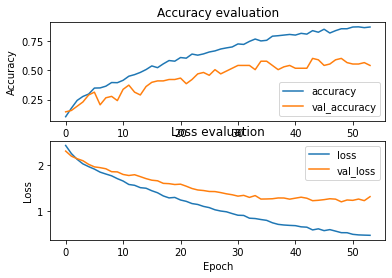

<Figure size 360x720 with 0 Axes>

In [ ]:
plot_history(history)

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)

3/3 [==============================] - 0s 11ms/step - loss: 1.4586 - accuracy: 0.5217


In [ ]:
test_loss

1.4585936069488525

In [ ]:
test_acc

0.52173912525177

In [ ]:
model_name = 'AnggotaTub_4.h5'
model.save(model_name, save_format='h5')

In [ ]:
%cd /content/drive/MyDrive/BANGKIT/FILE_H5 + PB

/content/drive/MyDrive/BANGKIT/FILE_H5 + PB


In [ ]:
name_model =  'AnggotaTubuh_2252.pb'
model.save(name_model, save_format='pb')

INFO:tensorflow:Assets written to: AnggotaTubuh_2252.pb/assets


In [ ]:
#preprocess the input sample function
def preprocess(file_path, num_mfcc=12, n_fft=2048, hop_length=512):
        """Extract MFCCs from audio file.
        :param file_path (str): Path of audio file
        :param num_mfcc (int): # of coefficients to extract
        :param n_fft (int): Interval we consider to apply STFT. Measured in # of samples
        :param hop_length (int): Sliding window for STFT. Measured in # of samples
        :return MFCCs (ndarray): 2-dim array with MFCC data of shape (# time steps, # coefficients)
        """
        signal, sample_rate = librosa.load(file_path)

        if len(signal) >= 22050:
            # ensure consistency of the length of the signal
            signal = signal[:22050]

            # extract MFCCs
            MFCCs = librosa.feature.mfcc(signal, sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                         hop_length=hop_length)
        return MFCCs.T

In [ ]:
loaded=tf.keras.models.load_model(model_name)

In [ ]:
def predict(file_path):
       
        # extract MFCC
        MFCCs = preprocess(file_path)

        # we need a 4-dim array to feed to the model for prediction: (# samples, # time steps, # coefficients, 1)
        MFCCs = MFCCs[np.newaxis, ..., np.newaxis]

        # get the predicted label
        predictions = loaded.predict(MFCCs)

        return predictions

In [ ]:
def prediksi(data_predict):
  print("Prediksi: \n")
  print("Pundak: "+str(data_predict[0,0]*100)+"%")
  print("Mata: "+str(data_predict[0,1]*100)+"%")
  print("perut: "+str(data_predict[0,2]*100)+"%")
  print("Pipi: "+str(data_predict[0,3]*100)+"%")
  print("Telinga: "+str(data_predict[0,4]*100)+"%")
  print("Gigi: "+str(data_predict[0,5]*100)+"%")
  print("Hidung: "+str(data_predict[0,6]*100)+"%")
  print("Jari: "+str(data_predict[0,7]*100)+"%")
  print("Lidah: "+str(data_predict[0,8]*100)+"%")
  print("Lutut: "+str(data_predict[0,9]*100)+"%")

In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/testing_hd.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 0.022729457123205066%
Mata: 0.008936093945521861%
perut: 0.05420082015916705%
Pipi: 0.07003643549978733%
Telinga: 0.22702247370034456%
Gigi: 0.15776107320562005%
Hidung: 94.76024508476257%
Jari: 0.47244238667190075%
Lidah: 4.101845994591713%
Lutut: 0.12479112483561039%


In [ ]:
def findmax(hasil):
  fin_max=max(hasil,key=hasil.get)

In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/testing_gg.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 0.0002963978431580472%
Mata: 0.00035359171306481585%
perut: 4.3049058717770095e-05%
Pipi: 7.359375059604645%
Telinga: 0.20227765198796988%
Gigi: 81.46303296089172%
Hidung: 2.9338186606764793%
Jari: 6.262736022472382%
Lidah: 1.7780464142560959%
Lutut: 1.9608653190061887e-05%


In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/testing_ld.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 1.6913756728172302%
Mata: 0.17182074952870607%
perut: 0.2119198441505432%
Pipi: 2.389836125075817%
Telinga: 11.351615935564041%
Gigi: 1.9493743777275085%
Hidung: 3.1373370438814163%
Jari: 23.542003333568573%
Lidah: 54.74501848220825%
Lutut: 0.8096994832158089%


In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/testing_mt.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 0.4147499334067106%
Mata: 89.08443450927734%
perut: 1.2098860926926136%
Pipi: 0.03885122714564204%
Telinga: 0.19291967619210482%
Gigi: 0.04810146056115627%
Hidung: 0.051622517639771104%
Jari: 8.596137911081314%
Lidah: 0.29109534807503223%
Lutut: 0.07220037514343858%


In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/gigi_cadel.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 5.331255437113214e-06%
Mata: 2.7870491692283395e-06%
perut: 3.823542815695191e-07%
Pipi: 2.7549684047698975%
Telinga: 0.005930757470196113%
Gigi: 96.8210756778717%
Hidung: 0.27330038137733936%
Jari: 0.09841943392530084%
Lidah: 0.04630506446119398%
Lutut: 7.038596372410666e-07%


In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/hidung_cadell.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 0.10419485624879599%
Mata: 0.01240416313521564%
perut: 0.018574261048343033%
Pipi: 2.268057130277157%
Telinga: 18.069030344486237%
Gigi: 10.404771566390991%
Hidung: 47.383275628089905%
Jari: 5.676085129380226%
Lidah: 15.60397744178772%
Lutut: 0.45963628217577934%


In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/ld_cadel.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 0.2397712552919984%
Mata: 0.056819082237780094%
perut: 0.028904381906613708%
Pipi: 0.4432047251611948%
Telinga: 11.77099272608757%
Gigi: 1.0735230520367622%
Hidung: 2.4987060576677322%
Jari: 18.690133094787598%
Lidah: 64.98424410820007%
Lutut: 0.21369988098740578%


In [ ]:
data_predict = predict("/content/drive/MyDrive/BANGKIT/mt_cadeell.wav")
prediksi(data_predict)

Prediksi: 

Pundak: 0.30370147433131933%
Mata: 95.00552415847778%
perut: 0.7466198410838842%
Pipi: 0.004362702020443976%
Telinga: 0.08757457253523171%
Gigi: 0.003498766091070138%
Hidung: 0.02116959512932226%
Jari: 3.3902212977409363%
Lidah: 0.4326076712459326%
Lutut: 0.0047122230171225965%


In [ ]:
import tensorflow as tf


print('\u2022 Using TensorFlow Version:', tf.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.8.2
• GPU Device Not Found. Running on CPU
